In [4]:
import numpy as np
import random
import gym as gym
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

In [5]:
Transition = namedtuple("Transition", ["s", "a", "s_1", "r", "done"])

a = Transition([0, 1, 2, 3], 0, [4, 5, 6, 7], 0, True)
print(a)

Transition(s=[0, 1, 2, 3], a=0, s_1=[4, 5, 6, 7], r=0, done=True)


In [12]:
# Proportional: I don't understand SumTrees
class PrioritisedReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.errors = []
        self.position = 0
        self.e = 0.1
        self.alpha = 0.5

    def push(self, item):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            self.errors.append(None)
        self.memory[self.position] = item
        self.errors[self.position] = 10000
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        probability = np.array(self.errors) ** self.alpha
        probability = probability / np.sum(probability)

        indices = np.random.choice(len(self.errors), size=batch_size, replace=False, p=probability)
        out = np.take(self.memory, indices, axis=0)
        batched = Transition(*zip(*out))
        s = np.array(list(batched.s))
        a = np.array(list(batched.a))
        s_1 = np.array(list(batched.s_1))
        r = np.expand_dims(np.array(list(batched.r)), axis=1)
        done = np.expand_dims(np.array(list(batched.done)), axis=1)
        return [s, a, s_1, r, done], indices

    def update(self, indices, errors):
        errors = np.absolute(errors)
        for i in range(len(indices)):
            self.errors[indices[i]] = errors[i] + self.e
    
    def __len__(self):
        return len(self.memory)

    def __str__(self):
        result = []
        for i in range(self.__len__()):
            result.append(self.memory[i].__str__() + " error:" + self.errors[i].__str__() + " \n")
        return "".join(result)
    
memory = PrioritisedReplayMemory(capacity=10)

for i in range(10):
    a = Transition([0, 1, 2, i], 0, [4, 5, 6, i*i], 0, True)
    memory.push(a)
    
sample, indices = memory.sample(2)
for i in range(len(sample)):
    print(sample[i])
print(indices)

memory.update(indices, [2, 5])
# print(sample[0].shape)
# print(sample[1].shape)
print(memory)

[[0 1 2 1]
 [0 1 2 4]]
[0 0]
[[ 4  5  6  1]
 [ 4  5  6 16]]
[[0]
 [0]]
[[ True]
 [ True]]
[1 4]
Transition(s=[0, 1, 2, 0], a=0, s_1=[4, 5, 6, 0], r=0, done=True) error:10000 
Transition(s=[0, 1, 2, 1], a=0, s_1=[4, 5, 6, 1], r=0, done=True) error:2.1 
Transition(s=[0, 1, 2, 2], a=0, s_1=[4, 5, 6, 4], r=0, done=True) error:10000 
Transition(s=[0, 1, 2, 3], a=0, s_1=[4, 5, 6, 9], r=0, done=True) error:10000 
Transition(s=[0, 1, 2, 4], a=0, s_1=[4, 5, 6, 16], r=0, done=True) error:5.1 
Transition(s=[0, 1, 2, 5], a=0, s_1=[4, 5, 6, 25], r=0, done=True) error:10000 
Transition(s=[0, 1, 2, 6], a=0, s_1=[4, 5, 6, 36], r=0, done=True) error:10000 
Transition(s=[0, 1, 2, 7], a=0, s_1=[4, 5, 6, 49], r=0, done=True) error:10000 
Transition(s=[0, 1, 2, 8], a=0, s_1=[4, 5, 6, 64], r=0, done=True) error:10000 
Transition(s=[0, 1, 2, 9], a=0, s_1=[4, 5, 6, 81], r=0, done=True) error:10000 



In [7]:
class DQNLinear(nn.Module):
    def __init__(self, *args):
        super(DQNLinear, self).__init__(*args)
        self.fc1 = nn.Linear(4, 128)
#         self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(128, 2)
        self.fcv = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        v = self.fcv(x)
        a = self.fc3(x)
        N = a.size()[1]
        q = v + 1/N * a
        
        return q

dqn = DQNLinear()
print(dqn)

# x = np.stack([screen, prev_screen], axis=2)
# x = np.expand_dims(x, axis=0)
# x = np.rollaxis(x, 3, 1)
x = torch.Tensor([1, 1, 1, 1])
x = torch.unsqueeze(x, 0)
x = Variable(x).float()
print(x.data.numpy().shape)
# print(x)
# x = Variable(torch.randn(2, 2, 180, 600))
        
output = dqn(x)
print(output.data.numpy().shape)

# create your optimizer
optimizer = optim.Adam(dqn.parameters(), lr=0.01)
criterion = nn.MSELoss()

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = dqn(x)
loss = criterion(output, Variable(torch.Tensor([0,0])))
loss.backward()
optimizer.step()    # Does the update

DQNLinear (
  (fc1): Linear (4 -> 128)
  (fc3): Linear (128 -> 2)
  (fcv): Linear (128 -> 1)
)
(1, 4)
(1, 2)


In [8]:
class Epsilon(object):
    def __init__(self, start=1.0, end=0.01, update_increment=0.01):
        self.start = start
        self.end = end
        self.update_increment = update_increment
        self._value = self.start
        self.isTraining = True
    
    def increment(self, count=1):
        self._value = max(self.end, self._value - self.update_increment*count)
        return self
        
    def value(self):
        if not self.isTraining:
            return 0.0
        else:
            return self._value
    
    
eps = Epsilon(start=1.0, end=0.01, update_increment=0.01)
print(eps.value())
print(eps.increment().value())
print(eps.increment().value())
print(eps.increment().value())
print(eps.increment(99).value())
eps.isTraining = False
print(eps.increment().value())
eps.isTraining = True
print(eps.increment().value())

1.0
0.99
0.98
0.97
0.01
0.0
0.01


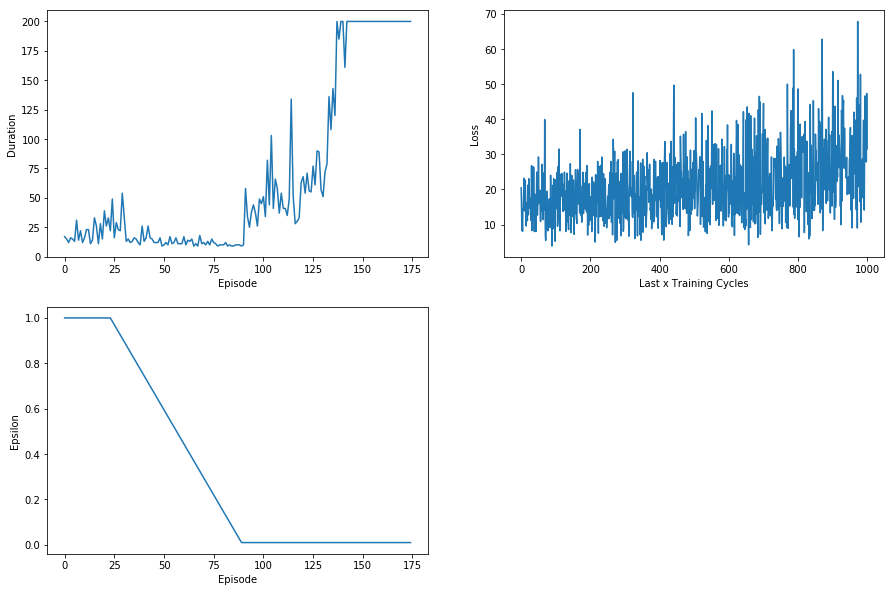

CPU times: user 4min 13s, sys: 5min 16s, total: 9min 29s
Wall time: 3min 57s


In [30]:
import copy
class DQNLinearLearner(object):
    def __init__(self, double_Q=False):
        self.env = gym.make("CartPole-v0")
        self.epsilon = Epsilon(start=1.0, end=0.01, update_increment=0.015)
        self.gamma = 0.99
        self.train_q_per_step = 4
        self.train_q_batch_size = 256
        self.steps_before_training = 500
        self.target_q_update_frequency = 100
        
        self.memory = PrioritisedReplayMemory(capacity=10000)
        self.Q = DQNLinear()
        self.Qt = copy.deepcopy(self.Q)# DQNLinear()
#         self.Qt.load_state_dict(self.Q.state_dict())
        self.use_double_Q = double_Q
        self.optimizer = optim.Adam(self.Q.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()

        self.reset()
        self.episode_rewards = []
        self.epsilon_log = []
        self.l_tq_squared_error = deque(maxlen=1000)
        

    def get_action(self, s):
        s = self.state_to_tensor(s)
        actions = self.Q(s)
        if np.random.rand() > self.epsilon.value():
            action = np.argmax(actions.data.numpy())
#             print(actions.data.numpy(), action)
#             print("not exploring", self.epsilon.value())
        else:
            action = self.env.action_space.sample()
#             print("exploring", action, "epsilon:", self.epsilon.value())
        return action

    def state_to_tensor(self, s):
        x = torch.Tensor(s)
        x = torch.unsqueeze(x, 0)
        x = Variable(x, volatile=True).float()
        return x
    
    def reset(self):
        self.s = self.env.reset()
    
    def train(self, nb_episodes=1, display=None):
        self.env = gym.make("CartPole-v0")
        self.epsilon.isTraining = True
        step = 0
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_action(self.s)
                s_1, r, done, _ = self.env.step(action)
                    
                transition = Transition(self.s, action, s_1, r, done)
                self.memory.push(transition)
                episode_reward += r
                step += 1
                self.s = s_1
                
                if done:
                    break
                
                if step % self.train_q_per_step == 0 and step > self.steps_before_training:
                    self.train_q()
                    
                if step % self.target_q_update_frequency == 0 and step > self.steps_before_training:
                    self.update_target_q()

                if display is not None and step % 100 == 0:
                    display(self)
                    
            if step > self.steps_before_training:
                self.epsilon.increment() # increment epsilon per episode
#             print("Episode reward: ", episode_reward)
            self.episode_rewards.append(episode_reward)
            self.epsilon_log.append(self.epsilon.value())

        if display is not None:
            display(self)
    
    def train_q(self):
#         print("training q. Memory size:", len(self.memory))
        if self.train_q_batch_size >= len(self.memory):
            return
        
        transition, indices = self.memory.sample(self.train_q_batch_size)
        s, a, s_1, r, done = transition
        s = Variable(torch.from_numpy(s)).float()
        a = Variable(torch.from_numpy(a)).long().unsqueeze(1)
        s_1 = Variable(torch.from_numpy(s_1), volatile=True).float()
        r = Variable(torch.from_numpy(r)).float()
        done = Variable(torch.from_numpy(1 - done)).float()
        

        Q = self.Q(s)
        Q = Q.gather(1, a)
        Qt = self.Qt(s_1)

        if self.use_double_Q:
            best_action = self.Q(s_1).max(dim=1)[1].view(-1, 1)
            y = r + done * self.gamma * Qt.gather(1, best_action)
        else:
            y = r + done * self.gamma * Qt.max(dim=1)[0].unsqueeze(1)

        y.volatile = False #weird

        loss = self.criterion(Q, y)
        error = Q - y
        self.memory.update(indices, error.squeeze().data.numpy())
#         loss = F.smooth_l1_loss(Q, y)
        self.l_tq_squared_error.append(loss.data.numpy().sum())
        self.optimizer.zero_grad()   # zero the gradient buffers
        loss.backward()
#         for param in self.Q.parameters():
#             param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def update_target_q(self):
        """Update the target Q-value function by copying the current Q-value function weights."""
#         self.Qt.load_state_dict(self.Q.state_dict())
        self.Qt = copy.deepcopy(self.Q)

    def run(self):
        self.env = gym.make("CartPole-v0")
        self.reset()
        self.epsilon.isTraining = False
#         self.env.render()
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_action(self.s)
            s_1, r, done, _ = self.env.step(action)
            episode_reward += r
            self.s = s_1

            if done:
                break;
        
        self.env.close()
        print("Total Reward: ", episode_reward)
    

learner = DQNLinearLearner(double_Q=True)

def show_chart(learner):
    plt.figure(figsize=(15,10))
    plt.subplot(2, 2, 1)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(learner.episode_rewards)
    plt.subplot(2, 2, 2)
    plt.xlabel('Last x Training Cycles')
    plt.ylabel('Loss')
    plt.plot(list(learner.l_tq_squared_error))
    plt.subplot(2, 2, 3)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.plot(list(learner.epsilon_log))
    display.clear_output(wait=True)
    display.display(plt.gcf())

%time learner.train(175, show_chart)
# learner.train(1)


In [29]:
learner.run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward:  173.0
